In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sunpy.time import parse_time
from sklearn import preprocessing

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *

import os
import shutil
import datetime
import sys
from pathlib import Path

sys.path.append(os.path.join(Path.cwd(), 'utils'))
from utils.resnet_model import *
from utils.lstm_model import *
from utils.region_detector import *
from utils.im_utils import *
from utils.data_augmentation import *

In [22]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
pd.set_option('display.max_rows', 500)

In [23]:
EVENTS_BY_DATE_DIR = './events_by_date'
AIA_DATA_DIR = '../../MVTS_data_preparation/data'
RESNET_CHECKPOINTS_DIR = './checkpoints/resnet_checkpoints'
LSTM_CHECKPOINTS_DIR = './checkpoints/lstm_checkpoints'

IMG_SIZE=128

In [24]:
def GetClosestDataFileByDate(dt, rounding):
    AIA_data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    tmp_dt = dt
    minute = 0
    
    if(rounding == "down"):
        minute = GetClosestMultipleDown(tmp_dt.minute, 6)
    elif(rounding == "up"):
        minute = GetClosestMultipleUp(tmp_dt.minute, 6)
    
    if(minute == 60):
        tmp_dt = tmp_dt + datetime.timedelta(hours=1)
        minute = 0
    
    AIA_data_time = f'{tmp_dt.hour:02d}{minute:02d}'
    AIA_data_filename = f'AIA{AIA_data_date}_{AIA_data_time}_0094.npz'
    
    return AIA_data_filename

In [25]:
def build_feature_extractor():
    feature_extractor = CustomResNet50(
        weights=None,
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 1),
    )
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))

    outputs = feature_extractor(inputs)
    
    return Model(inputs, outputs, name="feature_extractor")

In [26]:
def build_resnet_model():
    resnet_model = CustomResNet50(include_top=True)
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))
    outputs = resnet_model(inputs)
    model = Model(inputs, outputs, name="resnet_model")
    
    return model

In [27]:
def build_lstm_model():
    resnet_model = CustomResNet50(
        weights=None,
        include_top=True,
        input_shape=(IMG_SIZE, IMG_SIZE, 1),
    )
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))
    outputs = resnet_model(inputs)
    model = Model(inputs, outputs, name="resnet_model")
    
    return model

In [28]:
def PredictFlareStartLocationResnet(im, predictor):
    coord_cutout_dict = GetImageTopNRegionsCoordCutoutDict(im)
    predictions_dict = {}
    for k, v in coord_cutout_dict.items():
        # new_im = NormalizeData(v)
        new_im = cv2.resize(v, (128, 128), interpolation = cv2.INTER_AREA)
        new_im = np.array([new_im.reshape(128, 128, 1)])        
        predictions_dict[k] = predictor.predict(new_im, verbose=0)
    sorted_prediction_list = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1][0])}
    # sorted_prediction_list = list({k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1][0][1])})
    
    return sorted_prediction_list

In [29]:
def GetPositiveLabelFilepathsForYearMonth(year, month):
    positive_label_filenames = set()
    positive_label_filepaths = set()
    month_folder_csv = f'{EVENTS_BY_DATE_DIR}/{year:04}/{month}.csv'
    month_folder_path = f'{AIA_DATA_DIR}/{year:04}/{month:02}'
    if not os.path.exists(month_folder_csv):
        print(f'no such file: {month_folder_csv}')
        return
    month_df = pd.read_csv(month_folder_csv)
    
    for index, row in month_df.iterrows():
        event_dt = parse_time(row['event_starttime'], precision=0).datetime
        AIA_filename = GetClosestDataFileByDate(event_dt, 'down').rsplit('.', 1)[0]
        positive_label_filenames.add(AIA_filename)
    
    for subdir, dirs, files in os.walk(month_folder_path):
        for file in files:
            clean_filename = file.rsplit('.', 1)[0]
            if clean_filename in positive_label_filenames:
                positive_label_filepaths.add(os.path.join(subdir, file))
                
    return positive_label_filepaths

In [30]:
def RunExperiment(year, month, predict_function):
    dt = datetime.datetime(year, month, 7)
    filepaths = []
    for subdir, dirs, files in os.walk(f'../../MVTS_data_preparation/data/{year:04}/{month:02}'):
        for file in files:
            filepaths.append(os.path.join(subdir, file))
    filepaths = sorted(filepaths)
    
    for filepath in filepaths:
        im = np.load(filepath)['x']
        prediction_list = PredictFlareStartLocationResnet(im, predict_function)
        print(filepath.rsplit('/', 1)[1].rsplit('.', 1)[0])
        print(prediction_list)

In [31]:
# resnet_model = CustomResNet50(include_top=True)
# # resnet_model.load_weights(f'./resnet50_weights/checkpoints/resnet_checkpoints/sgd__estop_checkpoint')
# resnet_model.load_weights(f'{RESNET_CHECKPOINTS_DIR}/sgd_newdata_B_class_1e-3_checkpoint')

In [32]:
# model_lstm = get_sequence_model()
# model_lstm.load_weights(f'{LSTM_CHECKPOINTS_DIR}/newdata_adam_checkpoint')
# feature_extractor = CustomResNet50(include_top=False)
# feature_extractor.load_weights(f'{RESNET_CHECKPOINTS_DIR}/sgd_newdata_B_class_1e-3_checkpoint')

In [33]:
def SingleConvLSTMModel(batch_size):
    # Construct the input layer with no definite frame size.
    inp = Input(shape=(6, 64, 64, 1))

    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    # followed by a `Conv3D` layer for the spatiotemporal outputs.
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(inp)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = Dense(256, activation='relu')(x)
    # x = GlobalMaxPooling3D()(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.4)(x)
    # x = Dense(1, activation='sigmoid')(x)
    
    # Next, we will build the complete model and compile it.
    model = Model(inp, x)
    
    return model

In [34]:
def ConvLSTMModel(batch_size):
    inp = Input(shape=(12, 64, 64, 1))
    print(inp.shape)
    cutout_inp = tf.convert_to_tensor(inp[:, :6, :, :, :])
    print(cutout_inp.shape)
    full_inp = tf.convert_to_tensor(inp[:, 6:, :, :, :])
    
    x = SingleConvLSTMModel(batch_size)(cutout_inp)
    x = GlobalMaxPooling3D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inp, x)
    
    return model

In [61]:
batch_size=64
lstm_model = ConvLSTMModel(batch_size)

(None, 12, 64, 64, 1)
(None, 6, 64, 64, 1)


In [69]:
lstm_model.load_weights(f'{LSTM_CHECKPOINTS_DIR}/conv_lstm_trial_end_full')

In [70]:
year, month = 2016, 1
dt = datetime.datetime(year, month, 7)
filepaths = []
for subdir, dirs, files in os.walk(f'../data/{year:04}/{month:02}'):
    for file in files:
        filepaths.append(os.path.join(subdir, file))
filepaths = sorted(filepaths)

In [71]:
def run_lstm_test(filepaths, predictor):
    sequences = []
    for i in range(6, len(filepaths)):
        past_paths = filepaths[i-6:i]
        past_paths = np.array(past_paths)
        past_paths = np.tile(past_paths,(2,1))
        past_paths = np.concatenate(past_paths)
        # print(filepaths[i].rsplit('/', 1)[1].rsplit('.', 1)[0])
        past_data = np.array([np.load(x)['x'] for x in past_paths])
        past_data = [cv2.resize(v, (64, 64), interpolation = cv2.INTER_AREA) for v in past_data]
        # past_data = np.array(past_data)
        past_data = np.expand_dims(past_data, 3)
        sequences.append(past_data)
    sequences = np.array(sequences)
    for i, sequence in enumerate(sequences):
        p = predictor.predict(np.expand_dims(sequence, 0))
        print(f'time: {filepaths[i]} pred: {p}')

In [72]:
def PredictFlareStartLocationLSTM(filepaths, lstm_model):
    for i in range(6, len(filepaths)):
        cutouts_dict = {}
        past_paths = filepaths[i-6:i]
        past_paths = past_paths + past_paths
        past_data = [np.load(x)['x'] for x in past_paths]
        # past_data = [cv2.resize(v, (64, 64), interpolation = cv2.INTER_AREA) for v in past_data]
        roi_coords = GetImageTopNRegionsCoords(past_data[-1], 3)
        roi_coords = [(x[0], x[1]) for x in roi_coords]
        print(roi_coords)
        cutouts = []
        for im in past_data:
            for coord in roi_coords:                
                if coord in cutouts_dict:
                    cutouts_dict[coord].append(GetSafeCenteredCutout(im, 64, coord))
                else:
                    cutouts_dict[coord] = [GetSafeCenteredCutout(im, 64, coord)]
        
        for k, v in cutouts_dict.items():
            sequence = np.array(v)
            sequence = np.expand_dims(sequence, 0)
            sequence = np.expand_dims(sequence, 4)
            print(sequence.shape)
            print(k)
            p = lstm_model.predict(sequence)
            print(f'time: {filepaths[i]} pred: {p}')

In [73]:
# PredictFlareStartLocationLSTM(filepaths[200:256], lstm_model)

In [74]:
run_lstm_test(filepaths[200:256], lstm_model)

1/1 [==============================] - 0s 25ms/step
time: ../data/2016/01/01/AIA20160101_2000_0094.npz pred: [[0.91698056]]
1/1 [==============================] - 0s 26ms/step
time: ../data/2016/01/01/AIA20160101_2006_0094.npz pred: [[0.92030334]]
1/1 [==============================] - 0s 23ms/step
time: ../data/2016/01/01/AIA20160101_2012_0094.npz pred: [[0.9180782]]
1/1 [==============================] - 0s 21ms/step
time: ../data/2016/01/01/AIA20160101_2018_0094.npz pred: [[0.92170775]]
1/1 [==============================] - 0s 21ms/step
time: ../data/2016/01/01/AIA20160101_2024_0094.npz pred: [[0.91437143]]
1/1 [==============================] - 0s 21ms/step
time: ../data/2016/01/01/AIA20160101_2030_0094.npz pred: [[0.930929]]
1/1 [==============================] - 0s 26ms/step
time: ../data/2016/01/01/AIA20160101_2036_0094.npz pred: [[0.926128]]
1/1 [==============================] - 0s 26ms/step
time: ../data/2016/01/01/AIA20160101_2042_0094.npz pred: [[0.9211423]]
1/1 [=========

In [108]:
data_dir = './data/M_lstm_end_data_augmented_pair/train/positive/AIA20130111_0917_0094/0/full'
lstm_data = []
for subdir, dirs, files in os.walk(data_dir):
    for f in files:
        lstm_data.append(os.path.join(subdir, f))
lstm_data = sorted(lstm_data)
lstm_data = [np.load(x) for x in lstm_data]

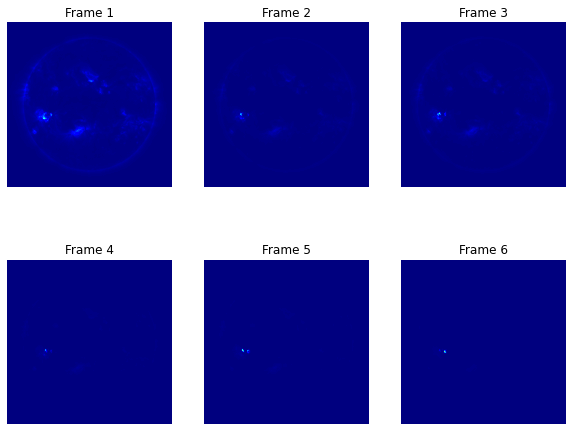

In [109]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(lstm_data[idx], cmap='jet')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()

In [106]:
data_dir = './data/M_lstm_end_data_augmented_pair/train/positive/AIA20130510_0108_0094/0/full'
lstm_data = []
for subdir, dirs, files in os.walk(data_dir):
    for f in files:
        lstm_data.append(os.path.join(subdir, f))
lstm_data = [
    '../data/2013/01/11/AIA20130111_0918_0094.npz',
    '../data/2013/01/11/AIA20130111_0924_0094.npz',
    '../data/2013/01/11/AIA20130111_0930_0094.npz',
    '../data/2013/01/11/AIA20130111_0936_0094.npz',
    '../data/2013/01/11/AIA20130111_0942_0094.npz',
    '../data/2013/01/11/AIA20130111_0948_0094.npz',
]
lstm_data = [np.load(x)['x'] for x in lstm_data]

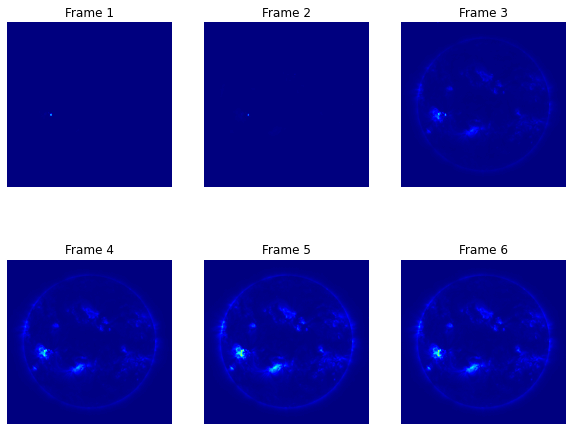

In [107]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(lstm_data[idx], cmap='jet')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()

In [124]:
lstm_data = [
    '../data/2011/03/23/AIA20110323_0206_0094.npz',
    '../data/2011/03/23/AIA20110323_0212_0094.npz',
    '../data/2011/03/23/AIA20110323_0218_0094.npz',
    '../data/2011/03/23/AIA20110323_0224_0094.npz',
    '../data/2011/03/23/AIA20110323_0230_0094.npz',
    '../data/2011/03/23/AIA20110323_0236_0094.npz',
]
lstm_data = [np.load(x)['x'] for x in lstm_data]
lstm_data = np.array(lstm_data)

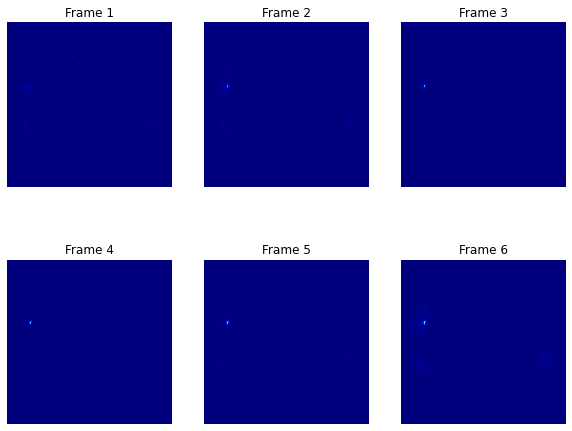

In [125]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(lstm_data[idx], cmap='jet')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()

In [106]:
lstm_model.predict([lstm_data])

1/1 [==============================] - 0s 28ms/step


array([[0.98826885]], dtype=float32)

In [60]:
lstm_data = []
start=0
past_paths = filepaths[start:6]
lstm_data=[np.load(x)['x'] for x in past_paths]
lstm_data = np.array(lstm_data)
for data in lstm_data:
    coord_cutout_dict = GetImageTopNRegionsCoordCutoutDict(data)
    print(coord_cutout_dict)

{(300, 56): array([[5.88881   , 5.7772207 , 6.7354517 , ..., 2.4696515 , 2.0313041 ,
        2.3255777 ],
       [5.2280717 , 5.3970695 , 6.4994917 , ..., 1.7139418 , 1.481528  ,
        2.3499293 ],
       [4.0105777 , 4.3544765 , 5.5669394 , ..., 2.4667153 , 1.4525135 ,
        2.1443708 ],
       ...,
       [1.0468515 , 0.92787105, 0.9009267 , ..., 4.6526437 , 3.9847286 ,
        3.5453854 ],
       [1.1604075 , 1.2792182 , 0.7561374 , ..., 5.7191906 , 4.9770584 ,
        3.8953276 ],
       [1.0466099 , 1.1041076 , 0.92891   , ..., 4.7044983 , 5.45885   ,
        4.2145414 ]], dtype=float32), (220, 56): array([[4.128731 , 4.465544 , 5.1370406, ..., 3.8949134, 3.0582168,
        3.048722 ],
       [4.300587 , 5.5103164, 6.180772 , ..., 4.067299 , 2.9635112,
        2.008975 ],
       [4.8516417, 5.7448325, 5.377482 , ..., 3.201767 , 3.1921587,
        2.7023644],
       ...,
       [6.0611815, 7.428046 , 8.394679 , ..., 2.7576585, 2.614178 ,
        3.048011 ],
       [5.6091413, 6

In [56]:
lstm_data.shape

(6, 512, 512)

In [52]:
fd = run_lstm_test()

AIA20160101_0036_0094
3
3
3
3
3
3


(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


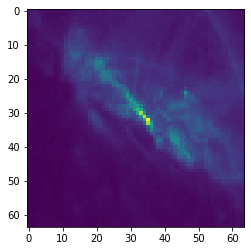

In [50]:
for k, v in fd.items():
    print(v.shape)
    plt.imshow(v)

In [14]:
RunExperiment(2016, 1, resnet_model)

2022-07-28 04:47:59.523769: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-28 04:48:00.121976: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 04:48:00.125650: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


AIA20160101_0000_0094
{(220, 56): array([[0.18115501]], dtype=float32), (300, 56): array([[0.21400368]], dtype=float32), (184, 428): array([[0.33496624]], dtype=float32)}
AIA20160101_0006_0094
{(220, 56): array([[0.17391884]], dtype=float32), (300, 56): array([[0.19661139]], dtype=float32), (196, 424): array([[0.29104155]], dtype=float32)}
AIA20160101_0012_0094
{(220, 56): array([[0.17784682]], dtype=float32), (300, 56): array([[0.2081101]], dtype=float32), (196, 424): array([[0.24235067]], dtype=float32)}
AIA20160101_0018_0094
{(220, 56): array([[0.18633507]], dtype=float32), (320, 376): array([[0.20881662]], dtype=float32), (188, 424): array([[0.5283402]], dtype=float32)}
AIA20160101_0024_0094
{(220, 56): array([[0.16978328]], dtype=float32), (272, 420): array([[0.17012985]], dtype=float32), (192, 416): array([[0.3246156]], dtype=float32)}
AIA20160101_0030_0094
{(272, 420): array([[0.17617774]], dtype=float32), (220, 56): array([[0.18836004]], dtype=float32), (192, 416): array([[0.54

KeyboardInterrupt: 

In [23]:
plf = GetPositiveLabelFilepathsForYearMonth(2016, 1)

In [24]:
plf

{'../../MVTS_data_preparation/data/2016/01/01/AIA20160101_0630_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/01/AIA20160101_0936_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/03/AIA20160103_2018_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/07/AIA20160107_1236_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/08/AIA20160108_1118_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/12/AIA20160112_1336_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/14/AIA20160114_1000_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/15/AIA20160115_1518_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_0730_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_0906_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_1112_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_1424_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_1700_0094.npz',
 '../../MVTS_data_preparation/data/201

In [9]:
feature_extractor = build_feature_extractor()
feature_extractor.load_weights('./checkpoints/resnet_checkpoints/my_checkpoint')
lstm_model = get_sequence_model()
lstm_model.load_weights('./checkpoints/lstm_checkpoints/my_checkpoint')

channels_last


In [97]:
dt = datetime.datetime(2016, 1, 7)
filepaths = []
for subdir, dirs, files in os.walk(f'../../MVTS_data_preparation/data/{dt.year}/{dt.month:02}/{dt.day:02}'):
    for file in files:
        filepaths.append(os.path.join(subdir, file))
filepaths = sorted(filepaths)

In [98]:
filepaths = filepaths[120:]

In [11]:
for file in filepaths:
    data = np.load(file)['x']
    print(file.rsplit('/', 1)[1].rsplit('.', 1)[0])
    PredictFlareStartLocation(data, resnet_model)
    print('-----------------------------------------------------------------------------------')

AIA20160101_0000_0094


2022-07-24 23:54:58.902164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-24 23:54:59.513596: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-24 23:54:59.517731: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


{(300, 56): array([[0.6072767]], dtype=float32), (220, 56): array([[0.64755785]], dtype=float32), (184, 428): array([[0.6926701]], dtype=float32)}
-----------------------------------------------------------------------------------
AIA20160101_0006_0094
{(300, 56): array([[0.6057599]], dtype=float32), (220, 56): array([[0.6482343]], dtype=float32), (196, 424): array([[0.68818605]], dtype=float32)}
-----------------------------------------------------------------------------------
AIA20160101_0012_0094


KeyboardInterrupt: 

In [1]:
# for i in range(6, len(filepaths)):
#     past_paths = filepaths[i-6:i]
#     print(filepaths[i].rsplit('/', 1)[1].rsplit('.', 1)[0])
#     past_data = np.array([np.load(x)['x'] for x in past_paths])
#     PredictFlareStartLocationLSTM(past_data, resnet_model, feature_extractor, lstm_model)
#     print('-----------------------------------------------------------------------------------')

In [46]:
t = np.load('../../MVTS_data_preparation/data/2016/10/14/AIA20161014_0730_0094.npz')['x']
coord_cutout_dict = GetImageTopNRegionsCoordCutoutDict(t)
# cutouts = [cv2.resize(x, (128, 128), interpolation = cv2.INTER_AREA) for x in cutouts]
# cutouts = np.array([x.reshape(128, 128, 1) for x in cutouts])

In [47]:
PredictFlareStartLocation(t, resnet_model)

1/1 [==============================] - 0s 33ms/step


{(312, 452): array([[0.5651931 , 0.43480688]], dtype=float32),
 (184, 432): array([[0.5637392, 0.4362608]], dtype=float32),
 (260, 112): array([[0.542031  , 0.45796898]], dtype=float32)}

In [6]:
resnet_model = build_resnet_model()
resnet_model.load_weights('./checkpoints/my_checkpoint')

channels_last


2022-07-24 00:00:00.456737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-24 00:00:01.063273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6656 MB memory:  -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:82:00.0, compute capability: 7.5


In [72]:
coord = ConvertHPCToPixXY((-605.9, -10))
coord = ResizeCoord(coord)

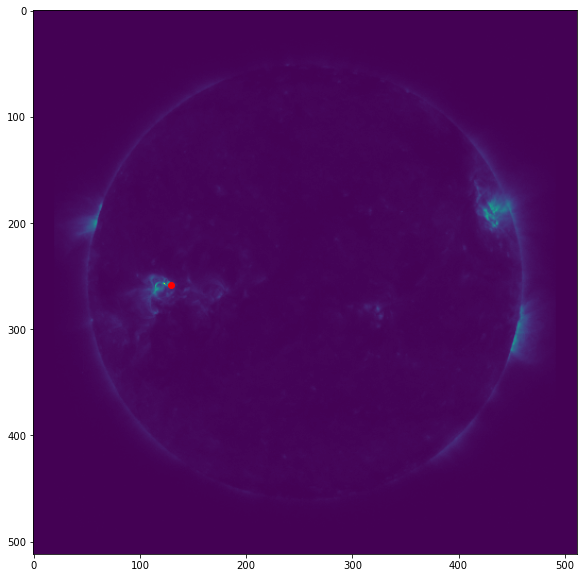

In [73]:
plt.figure(figsize=(10, 10))
plt.imshow(t)
plt.scatter(coord[0], coord[1],color='r')

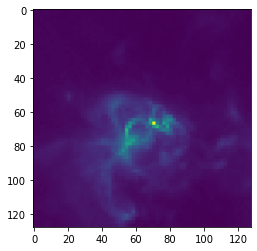

In [76]:
plt.imshow(cutouts[1])

In [73]:
from sunpy.net import attrs as a
from sunpy.net import Fido
tstart = '2010/01/01 00:00:00'
tend = '2019/01/01 00:30:00'
event_type = 'FL'
result = Fido.search(a.Time(tstart,tend), a.hek.EventType(event_type))

KeyboardInterrupt: 

In [ ]:
event_table = result['hek']["event_starttime", "event_peaktime", "event_endtime", "fl_goescls", "ar_noaanum", "event_c1error", "event_c2error"]
event_df = event_table.to_pandas().rename(columns={
    'event_starttime': 'start_time',
    'event_peaktime': 'peak_time',
    'event_endtime': 'end_time',
    'fl_goescls': 'goes_class',
    #'hgc_coord': 'goes_location',
    'ar_noaanum': 'noaa_active_region',
})

In [ ]:
event_df[event_df['event_c1error'] != event_df['event_c2error']]